In [10]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyfits
import plotc
import read_params
import os
def fitsread(f): return np.squeeze(pyfits.getdata(f)).astype(float)
from matplotlib.ticker import MaxNLocator,MultipleLocator

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Times']})

In [3]:
datadir = read_params.get_directory()
src = 4
src_loc = np.loadtxt(os.path.join(datadir,"master.pixels"))[src-1]
print "Source at",src_loc

Source at -2.0


In [5]:
true_wavefield = fitsread(os.path.join(datadir,"tt","data","data"+str(src).zfill(2)+".fits"))
nt = true_wavefield.shape[0]
t = np.arange(nt)*dt

In [7]:
nx = read_params.get_nx()
Lx = read_params.get_xlength()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
Rsun = 695.8
dt = read_params.get_dt()
dx=Lx/nx
t_edges = (np.arange(nt+1)*dt-dt/2)/3600
x_edges = np.linspace(-Lx/2-dx/2,Lx/2-dx/2,nx+1)-src_loc

k = np.fft.fftshift(np.fft.fftfreq(nx,Lx/nx)*2*np.pi)
dk = k[1]-k[0]
k_edges = np.linspace(k[0]-dk/2,k[-1]+dk/2,nx+1)

nu = np.fft.fftshift(np.fft.fftfreq(nt,dt))*1e3
dnu = nu[1]-nu[0]
nu_edges = np.linspace(nu[0]-dnu/2,nu[-1]+dnu/2,nt+1)

def ind_rec(receiver_dist):
    receiver_loc=x[abs(x-(src_loc+receiver_dist)).argmin()]
    return int((receiver_loc/Lx+0.5)*nx)

## Time Distance

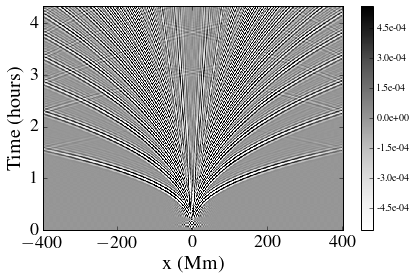

In [13]:
fig=plt.figure()
datamax = abs(true_wavefield).max()/40
plt.pcolormesh(x_edges,t_edges,true_wavefield,cmap="Greys",vmax=datamax,vmin=-datamax,rasterized=True)
cb=plt.colorbar(format='%.1e')
plt.xlim(x_edges[0],x_edges[-1])
plt.ylim(t_edges[0],t_edges[-1])
plt.xlabel("x (Mm)",fontsize=20)
plt.ylabel("Time (hours)",fontsize=20)

ax=plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(1))

plt.tick_params(axis="both",labelsize=18)

fig.set_size_inches(6,4)
plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/time_distance_true_model.eps")

In [5]:
starting_wavefield = fitsread(os.path.join(datadir,"tt","iter00","vz_cc_src"+str(src).zfill(2)+".fits"))
fmode_filter = fitsread('fmode_filter.fits')
true_fmode_waveform = np.fft.ifft2(np.fft.fft2(true_wavefield)*fmode_filter).real
starting_fmode_waveform = np.fft.ifft2(np.fft.fft2(starting_wavefield)*fmode_filter).real

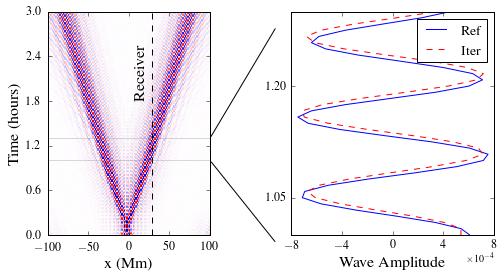

In [8]:
receiver_dist = 30
t_span_low = 1
t_span_high = 1.3

p=plotc.colorplot(starting_fmode_waveform,x=x,y=t/3600,cmap='seismic',
                  centerzero=True,sp=121,xr=[-100,100],yr=[0,3]);
p.axis.axvline(src_loc+receiver_dist,color="black",ls="dashed")
for y in [t_span_low,t_span_high]: p.axis.axhline(y,color="grey",alpha=0.3)
plt.ylabel("Time (hours)",fontsize=16)
plt.xlabel("x (Mm)",fontsize=16)
p.axis.text(5,1.8,"Receiver",fontsize=16,rotation='vertical',
            horizontalalignment='left',verticalalignment='bottom')
plt.tick_params(axis='both', which='major', labelsize=12)

ax2=plt.subplot(122)
plt.plot(true_fmode_waveform[:,ind_rec(receiver_dist)],t/3600,label="Ref");
plt.plot(starting_fmode_waveform[:,ind_rec(receiver_dist)],t/3600,ls="dashed",color="red",label="Iter");
ax2.xaxis.set_major_locator(MaxNLocator(4))
ax2.yaxis.set_major_locator(MaxNLocator(3))
plt.ticklabel_format(style="sci",scilimits=(0,0),axis="x")
plt.legend(loc="best",fontsize=14)

plt.xlabel("Wave Amplitude",fontsize=16)

plt.ylim(t_span_low,t_span_high)

plt.gcf().set_size_inches(8,4);
#plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
p.colorbar.ax.set_visible(False)

arrowKwargs = dict([('arrowstyle','-'), ('color','black'), ('linewidth',1)] )
for (y1,y2) in [(0,t_span_low),(1,t_span_high)]:
    p.axis.annotate('',xy=ax2.get_position().corners()[y1],xytext=[100,y2],
                    arrowprops=arrowKwargs,
                    xycoords='figure fraction', textcoords='data')

plt.tick_params(axis='both', which='major', labelsize=12)
if not os.path.exists('plots'): os.makedirs('plots')
plt.savefig('plots/f_mode_waveform.eps')

## Spectrum

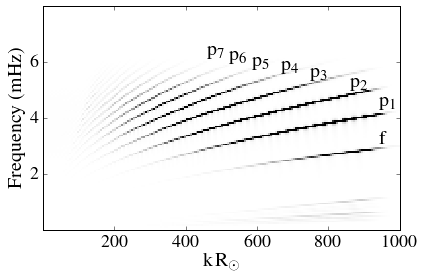

In [20]:
fig = plt.figure()
data_spec= np.fft.fftshift(abs(np.fft.fft2(true_wavefield))**2)
plt.pcolormesh(k_edges*Rsun,nu_edges,data_spec,cmap='Greys',vmax=data_spec.max()*0.2,rasterized=True)
ax = plt.gca()

plt.xlim(0,1000)
plt.ylim(0,8)

ax.xaxis.set_major_locator(MaxNLocator(5,prune="lower"))
ax.yaxis.set_major_locator(MaxNLocator(5,prune="both"))

plt.xlabel(r"$\mathrm{k\,R_\odot}$",fontsize=20,labelpad=5)
plt.ylabel(r"Frequency (mHz)",fontsize=20)

plt.text(943,3.1,r"f",     fontsize=20)
plt.text(943,4.35,r"p$_1$",fontsize=20)
plt.text(860,5.05,r"p$_2$",fontsize=20)
plt.text(750,5.4,r"p$_3$", fontsize=20)
plt.text(667,5.67,r"p$_4$",fontsize=20)
plt.text(587,5.8,r"p$_5$", fontsize=20)
plt.text(521,6.0,r"p$_6$", fontsize=20)
plt.text(460,6.2,r"p$_7$", fontsize=20)

plt.tick_params(axis="both",labelsize=18)
fig.set_size_inches(6,4)
plt.tight_layout()

if not os.path.exists('plots'): os.makedirs('plots')
plt.savefig('plots/spectrum_true_waveform.eps')